In [ ]:
#Import Library
import string   # memanipulasi tipe data string
import pandas as pd # memanipulasi dan menganalisis data -> series/dataframe
import numpy as np # memanipulasi dalam bentuk array
import os # berinteraksi dengan sistem operasi (manipulasi file dan direktori)
!pip install nltk
from nltk.tokenize import word_tokenize
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# Download data tokenisasi NLTK
nltk.download('punkt')
!pip install Sastrawi

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.0 MB/s eta 0:00:00


In [ ]:
# mengkoneksikan google colab dengan direktori drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# IMPORTING DATASET
Dataset didapatkan menggunakan teknik web scraping dari website google playstore dengan Google Scraper
> library pandas digunakan untuk menampilkan dan membaca dataset

In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/SEMESTER5/PSC1/Prak_FadilaRizka/Model/ulasand-sentiment.csv", sep=",", encoding="utf-8")
data.head(10)

,Review,sentiment
0,Kenapa kasih rate jelek? :( Developer ini memb...,1
1,Saya merasa bahwa aplikasi berjalan dengan lam...,-1
2,aku baru download sih.... msh blm genap 3kg. t...,1
3,Aplikasinya keren bisa membantu supaya dapat d...,1
4,"Sangat berharap bisa buka app ini, tp setelah ...",1
5,"Sering nya nggak ada yg pick up, jadi kita har...",1
6,"Gak bisa registnya, ketika telephone masuk oto...",-1
7,"Aplikasinya bagus, semoga secepatnya bisa dike...",1
8,Harga sampah plastiknya terlalu murah banget. ...,-1
9,Memutuskan untuk meng-uninstall aplikasi ini. ...,-1


In [ ]:
total_data = len(data)
print(f"Total jumlah dataset: {total_data}")

Total jumlah dataset: 1802


In [ ]:
# Menampilkan beberapa baris pertama dataframe
print("Dataframe awal:")
print(data['sentiment'].value_counts())

Dataframe awal:
 1    1152
-1     410
 0     240
Name: sentiment, dtype: int64


In [ ]:
data.isnull().sum()

Review       0
sentiment    0
dtype: int64

In [ ]:
# menghitung jumlah ulasan yang duplikasi
data.duplicated().sum()

73

In [ ]:
data[data.duplicated()]

,Review,sentiment
677,Semoga bermanfaat,1
681,Semoga bermanfaat,1
706,Mantap,1
712,Bagus,1
713,duitin loves the earth,1
...,...,...
1789,mantap,1
1791,Bagus,1
1792,Mantap,1
1794,Baik,1


In [ ]:
# menghapus duplikasi ulasan agar nantinya model tidak mempelajari kata yang sama secara berulang
data.drop_duplicates(inplace=True)

In [ ]:
# mengecek kembali jumlah duplikat setelah di hapus
data.duplicated().sum()

0

In [ ]:
# Menampilkan beberapa baris pertama dataframe
print("Dataframe setelah menghapus data duplikat:")
print(data['sentiment'].value_counts())

Dataframe setelah menghapus data duplikat:
 1    1081
-1     410
 0     238
Name: sentiment, dtype: int64


# PROSES PREPROCESSING DATA




## **Balancing Dataset**

In [ ]:
# Tentukan jumlah sampel yang diinginkan
jml_sample = 300

# Filter untuk review yang hanya satu kata atau kalimatnya sedikit
data_filtered = data[data['Review'].apply(lambda x: len(str(x).split())) > 5]

# Fungsi untuk melakukan balancing data dimulai dari index awal
def balance_data(group):
    return group.head(jml_sample)

# Menggunakan apply dan axis untuk melakukan balancing data
data = data_filtered.groupby('sentiment', group_keys=False).apply(balance_data)

print(data)

                                                Review  sentiment
1    Saya merasa bahwa aplikasi berjalan dengan lam...         -1
6    Gak bisa registnya, ketika telephone masuk oto...         -1
8    Harga sampah plastiknya terlalu murah banget. ...         -1
9    Memutuskan untuk meng-uninstall aplikasi ini. ...         -1
10   Pertama order tahun 2021 berhasil . Meskipun l...         -1
..                                                 ...        ...
614  Bagus.. semoga kedepannya bisa sampai Kab. Ser...          1
618           SEMOGA CEPAT BISA MENCAKUP AREA DI BALI🙏          1
622               Untuk area cakupan karawang ada kah?          1
625                   Wilayah kerja nya dimana aja min          1
626                 Saya br mw coba sapa tau beruntung          1

[805 rows x 2 columns]


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 805 entries, 1 to 626
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     805 non-null    object
 1   sentiment  805 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 18.9+ KB


In [ ]:
data['sentiment'].value_counts()

#1 sebagai Positif
#0 Sebagai Netral
#-1 Sebagai Negatif

-1    300
 1    300
 0    205
Name: sentiment, dtype: int64

##  **Case Folding**
> Mengambil string sebagai input mengubahnya menjadi huruf kecil dengan menggunakan metode lower

In [ ]:
data['Review'] = data['Review'].str.lower()
data.head()

,Review,sentiment
1,saya merasa bahwa aplikasi berjalan dengan lam...,-1
6,"gak bisa registnya, ketika telephone masuk oto...",-1
8,harga sampah plastiknya terlalu murah banget. ...,-1
9,memutuskan untuk meng-uninstall aplikasi ini. ...,-1
10,pertama order tahun 2021 berhasil . meskipun l...,-1


## **Filtering**

In [ ]:
# "Remove regex" merujuk pada penggunaan regular expression (regex) untuk menghapus atau mengganti pola tertentu dalam sebuah string atau dataset.
import re
import string
def cleansing(Review) :
  #menghapus karakter whitespace
  Review = Review.strip(" ")
  #url
  Review = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", Review)
  Review = re.sub(r'\(cont\)'," ", Review)
  #punctuatuion (hapus simbol'[!#?,.:";@()-/\']')
  Review = re.sub('[!"”#$%&’()*+,-./:;<=>?@[\]^`{|}~]', ' ', Review)
  #hapus #tagger
  Review = re.sub(r'#([^\s]+)', '', Review)
  #numeric
  Review = re.sub(r'\d+', ' ', Review)
  Review = re.sub(r'²', ' ', Review)
  Review = pd.Series(Review)


  return Review
data['Review'] = data['Review'].apply(cleansing)
data.head(10)

,Review,sentiment
1,saya merasa bahwa aplikasi berjalan dengan lam...,-1
6,gak bisa registnya ketika telephone masuk oto...,-1
8,harga sampah plastiknya terlalu murah banget ...,-1
9,memutuskan untuk meng uninstall aplikasi ini ...,-1
10,pertama order tahun berhasil meskipun lama...,-1
13,applikasinya sangat bagus tapi sayang sete...,-1
15,pada saat mau memasukan kode otp yang dikataka...,-1
22,sudah memasukan kode verifikasi digit terakh...,-1
29,ini kenapa pas mau masukin profil data alamat ...,-1
30,tolong segera di perbaiki saya mengalami crash...,-1


In [ ]:
# Fungsi untuk menghapus emotikon dari teks
def remove_emoticons(text):
    emoticon_pattern = re.compile("["
                                  u"\U0001F600-\U0001F64F"  # Emoticons
                                  u"\U0001F300-\U0001F5FF"  # Simbols & Pictographs
                                  u"\U0001F680-\U0001F6FF"  # Transport & Map Symbols
                                  u"\U0001F700-\U0001F77F"  # Alphabetic Presentation Forms
                                  u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                                  u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                                  u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                                  u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                                  u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                                  u"\U00002702-\U000027B0"  # Dingbats
                                  u"\U000024C2-\U0001F251"
                                  "]+", flags=re.UNICODE)
    return emoticon_pattern.sub(r'', text)


In [ ]:
# Menghapus emotikon dari kolom 'review'
data['Review'] = data['Review'].apply(remove_emoticons)

In [ ]:
print("\nDataframe setelah penghapusan emotikon:")
print(data.head(12))


Dataframe setelah penghapusan emotikon:
                                               Review  sentiment
1   saya merasa bahwa aplikasi berjalan dengan lam...         -1
6   gak bisa registnya  ketika telephone masuk oto...         -1
8   harga sampah plastiknya terlalu murah banget  ...         -1
9   memutuskan untuk meng uninstall aplikasi ini  ...         -1
10  pertama order tahun   berhasil   meskipun lama...         -1
13  applikasinya sangat bagus     tapi sayang sete...         -1
15  pada saat mau memasukan kode otp yang dikataka...         -1
22  sudah memasukan kode verifikasi   digit terakh...         -1
29  ini kenapa pas mau masukin profil data alamat ...         -1
30  tolong segera di perbaiki saya mengalami crash...         -1
32  untuk kode otp   digit angka terakhir tidak bi...         -1
40  kode otp gak muncul  padahal udah berulang kal...         -1


## **TOKENIZATION**

In [ ]:
# Fungsi tokenization
def tokenize_text(text):
    return word_tokenize(text)

# Terapkan tokenization pada kolom teks
data['Review'] = data['Review'].apply(tokenize_text)

# Tampilkan hasil
data[['Review']].head()

,Review
1,"[saya, merasa, bahwa, aplikasi, berjalan, deng..."
6,"[gak, bisa, registnya, ketika, telephone, masu..."
8,"[harga, sampah, plastiknya, terlalu, murah, ba..."
9,"[memutuskan, untuk, meng, uninstall, aplikasi,..."
10,"[pertama, order, tahun, berhasil, meskipun, la..."


## **SlangWord**

In [ ]:
path_dataslang = open("/content/gdrive/MyDrive/SEMESTER5/PSC1/Prak_FadilaRizka/Model/kamus kata baku.csv")
dataslang = pd.read_csv(path_dataslang, encoding='utf-8', header=None, sep=",")

def replaceSlang(word):
    if word in list(dataslang[0]):
        indexslang = list(dataslang[0]).index(word)
        return dataslang[1][indexslang]
    else:
        return word

data['Review'] = data['Review'].apply(lambda x: [replaceSlang(word) for word in x])
print(data['Review'])

1      [saya, merasa, bahwa, aplikasi, berjalan, deng...
6      [tidak, bisa, registrasinya, ketika, telepon, ...
8      [harga, sampah, plastiknya, terlalu, murah, ba...
9      [memutuskan, untuk, meng, uninstall, aplikasi,...
10     [pertama, order, tahun, berhasil, meskipun, la...
                             ...                        
614    [bagus, semoga, kedepannya, bisa, sampai, kab,...
618      [semoga, cepat, bisa, mencakup, area, di, bali]
622           [untuk, area, cakupan, karawang, ada, kah]
625           [wilayah, kerja, nya, dimana, saja, admin]
626       [saya, baru, mau, coba, siapa, tau, beruntung]
Name: Review, Length: 805, dtype: object


## **STOPWORDS**
kata kata umum yang tidak memiliki banyak arti, yang sering dihilangkan dari data teks untuk meningkatkan akurasi analisis.
> Pustaka Stopwords diambil dari nltk.corpus, digunakan untuk mendapatkan daftatr stopwords dalam bahasa Id dan Eng

> Stopwords Removal -> untuk mendefinisian dalam code, mengambil daftar kata sebagai masukan dan menghapus kata2 yang ada dalam daftar stopwords

> Stopwords adalah kata-kata umum yang sering diabaikan dalam analisis teks karena mereka tidak memberikan banyak informasi.

In [ ]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Inisialisasi StopWordRemover
factory = StopWordRemoverFactory()
ind_stopword = factory.get_stop_words()
def stopword(line):
  temp = list()
  for word in line:
    if(word not in ind_stopword):
      word = re.sub(r'[^a-zA-Z]','',word)
      if(len(word)>3):
        temp.append(word)
  return temp

data_katapenting = [stopword(line) for line in data['Review']]
data['Review'] = data_katapenting
print(data['Review'])

1      [merasa, aplikasi, berjalan, lambat, masuk, pe...
6      [registrasinya, telepon, masuk, otomatis, siny...
8      [harga, sampah, plastiknya, terlalu, murah, ba...
9      [memutuskan, meng, uninstall, aplikasi, aplika...
10     [pertama, order, tahun, berhasil, meskipun, la...
                             ...                        
614    [bagus, semoga, kedepannya, serang, kota, cile...
618                [semoga, cepat, mencakup, area, bali]
622                            [area, cakupan, karawang]
625                              [wilayah, kerja, admin]
626                       [baru, coba, siapa, beruntung]
Name: Review, Length: 805, dtype: object


## **Stemming**

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
ind_stemmer = factory.create_stemmer()

def stemmer(line):
  temp = list()

  for word in line:
      word = ind_stemmer.stem(word)
      temp.append(word)
  return temp

data_katapenting = [stemmer(line) for line in data['Review']]
data['Review'] = data_katapenting
print(data['Review'])


1      [rasa, aplikasi, jalan, lambat, masuk, tentu, ...
6      [registrasi, telepon, masuk, otomatis, sinyal,...
8      [harga, sampah, plastik, terlalu, murah, bange...
9      [putus, meng, uninstall, aplikasi, aplikasi, n...
10     [pertama, order, tahun, hasil, meski, lama, se...
                             ...                        
614    [bagus, moga, depan, serang, kota, cilegon, ba...
618                      [moga, cepat, cakup, area, bal]
622                              [area, cakup, karawang]
625                              [wilayah, kerja, admin]
626                          [baru, coba, siapa, untung]
Name: Review, Length: 805, dtype: object


# FEATURES EXTRACTION

## **Proses TF IDF**
Statistik numerik yang mencerminkan seberapa penting sebuah kata untuk sebuah dokumen dalam koleksi/corpus. Term Frequency-Inverse Document Frequency (TF-IDF)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Membuat vektor fitur
vectorizer = TfidfVectorizer()
reviews = [" ".join(r) for r in data["Review"]]
data_vektor = vectorizer.fit_transform(reviews)
data_vektor = data_vektor.toarray()
data_vektor.shape

(805, 1475)

# SPLITTING DATA

In [ ]:
x = data_vektor
y = data['sentiment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y , train_size=0.8)

# MODELING (SVM)

In [ ]:
for c in[0.01, 0.05, 0.5, 1]:

  sv = SVC(C=c)
  sv.fit(X_train, y_train)

  print('Accuracy for C=%s: %s'
      % (c, accuracy_score(y_test, sv.predict(X_test))))

Accuracy for C=0.01: 0.3416149068322981
Accuracy for C=0.05: 0.3416149068322981
Accuracy for C=0.5: 0.5217391304347826
Accuracy for C=1: 0.546583850931677


In [ ]:
final_model_sv = SVC(C=1)
final_model_sv.fit(x, y)

print('Final Model Accuracy %s' %accuracy_score(y_test, final_model_sv.predict(X_test)))

Final Model Accuracy 0.9751552795031055


In [ ]:
y_pred = final_model_sv.predict(X_test)
accuracy_score(final_model_sv.predict(X_test),y_test)

0.9751552795031055

# EVALUASI

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


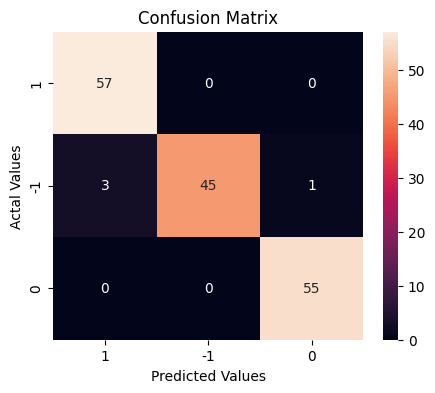

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['1','-1','0'],
                     columns = ['1','-1','0'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.95      1.00      0.97        57
           0       1.00      0.92      0.96        49
           1       0.98      1.00      0.99        55

    accuracy                           0.98       161
   macro avg       0.98      0.97      0.97       161
weighted avg       0.98      0.98      0.97       161



In [ ]:
import pickle
with open("SentimentAnalisis.pkl", "wb") as f:
    pickle.dump(final_model_sv, f)